<a href="https://colab.research.google.com/github/anurag-176/Python/blob/master/neural_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import tensorflow.contrib.eager as tfe

import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

from skimage import exposure

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
content_dir = "/content/gdrive/My Drive/Datasets/me2.jpg"
style_dir = "/content/gdrive/My Drive/Datasets/style2.jpg"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def load_image(path):
  dim = 512
  img = cv2.imread(path)
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  print("Image dimensions: ",img.shape)
  long = max(img.shape)
  print("longest dim: ",long)
  scale = dim/long
  img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)))
  img = np.expand_dims(img, axis=0)
  return img

In [0]:
def imshow(img, title=None):
  # Remove the batch dimension
  if len( img.shape) == 4:
    out = np.squeeze(img, axis=0)
  else:
    out = np.array(img)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)

In [5]:
c_I = load_image(content_dir)
s_I = load_image(style_dir)

Image dimensions:  (3264, 2448, 3)
longest dim:  3264
Image dimensions:  (450, 450, 3)
longest dim:  450


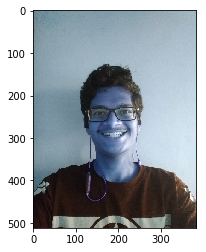

In [6]:
imshow(c_I)

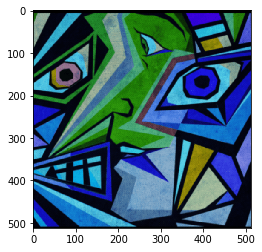

In [7]:
imshow(s_I)

In [0]:
def deprocess_img(processed_img):
  #x = processed_img.copy()
  x = processed_img
  if len(x.shape) == 4:
    x = np.array(tf.squeeze(x, axis=0))
    print("okay")
  x = np.array(x)
  #assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
  #                           "dimension [1, height, width, channel] or [height, width, channel]")
  #print("shape is:",x.shape)
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  #x *= 255
  # perform the inverse of the preprocessiing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
		            'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def get_model():
  vgg = tf.keras.applications.vgg19.VGG19(include_top = False, weights = 'imagenet')
  vgg.trainable = False
  style_outputs = [vgg.get_layer(name).output for name in style_layers]
  content_outputs = [vgg.get_layer(name).output for name in content_layers]
  model_outputs = style_outputs+content_outputs
  return tf.keras.Model(vgg.input, model_outputs)
vgg_model = get_model()

In [0]:
def gram_matrix(input_tensor):
  # We make the image channels first 
  channels = int(input_tensor.shape[-1])
  a = tf.reshape(input_tensor, [-1, channels])
  n = tf.shape(a)[0]
  gram = tf.matmul(a, a, transpose_a=True)
  return gram / tf.cast(n, tf.float32)

In [0]:
def get_features(image):
  #image = np.reshape(image, (1,512,512,3))
  image = tf.keras.applications.vgg19.preprocess_input(image)
  outputs = vgg_model(image)
  style_outputs, content_outputs = outputs[:num_style_layers], outputs[num_style_layers:]
  style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
  
  content_dict = {content_name:value for content_name, value in zip(content_layers, content_outputs)}
  style_dict = {style_name:value for style_name, value in zip(style_layers, style_outputs)}
  
  return {'content':content_dict, 'style':style_dict}

In [0]:
target_style = get_features(s_I)['style']
target_content = get_features(c_I)['content']

In [0]:
output_image = tfe.Variable(c_I, dtype=tf.float32)

In [0]:
def clip_0_1(image):
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means 
  return tf.clip_by_value(image, clip_value_min = min_vals, clip_value_max = max_vals)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

In [0]:
style_weight=1e-2
content_weight=1e3

In [0]:
def get_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  
  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - target_style[name])**2) for name in style_outputs.keys() ])
  style_loss *= style_weight/num_style_layers
  
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - target_content[name])**2) for name in content_outputs.keys() ])
  content_loss *= content_weight/num_content_layers
  
  loss = content_loss + style_loss
  return loss

In [0]:
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = get_features(image)
    loss = get_loss(outputs)
    
  gradients = tape.gradient(loss, image)
  optimizer.apply_gradients([(gradients, image)])
  image.assign(clip_0_1(image))
  return loss

W0713 16:25:08.740636 139858922514304 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1205: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


okay


'\nplt.subplot(1,2,2)\nplt.imshow(tf.squeeze(output_image, axis=0))\n'

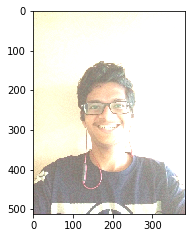

In [20]:
train_step(output_image)
op_img = deprocess_img(output_image)
plt.subplot(1,2,1)
plt.imshow(op_img)

In [22]:
print(op_img)

[[[241 221 190]
  [255 242 211]
  [255 255 225]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 240 205]
  [254 244 207]
  [255 252 215]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 226]
  [255 251 212]
  [255 255 228]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[148 137 130]
  [148 128 130]
  [148 128 129]
  ...
  [178 153 161]
  [179 153 154]
  [168 144 145]]

 [[151 131 133]
  [148 127 130]
  [149 129 132]
  ...
  [158 142 143]
  [163 147 148]
  [184 159 162]]

 [[146 134 130]
  [148 129 130]
  [152 141 143]
  ...
  [177 152 153]
  [182 158 167]
  [181 166 164]]]


301


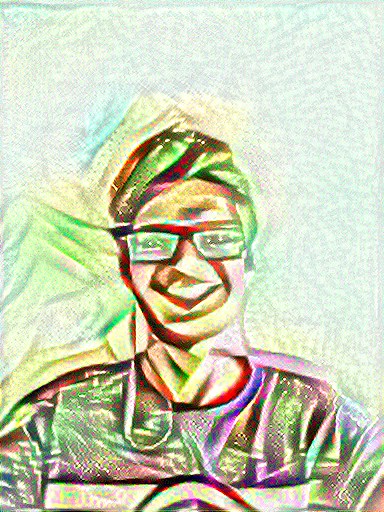

...................................................................................................Total time:  51.28463172912598


In [23]:
import IPython.display as display

import time
start = time.time()

iteration = 400

loss1 = float('inf')

step = 0
for n in range(iteration):
  step += 1
  loss = train_step(output_image)
  print(".", end = '')
  if n % 100 == 0:
    display.clear_output(wait=True)
    print(step)
    op_img = tf.squeeze(output_image, axis=0)
    outs = deprocess_img(op_img)
    display.display_png(Image.fromarray(outs))
    
  if loss < loss1:
    best_image = op_img
    loss1 = loss
  
end = time.time()
print("Total time: ", end-start)

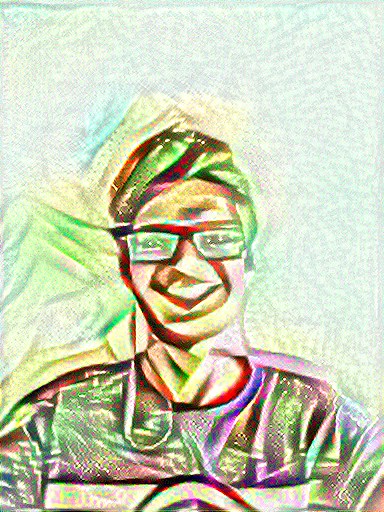

In [24]:
dI = deprocess_img(op_img)
Image.fromarray(dI)

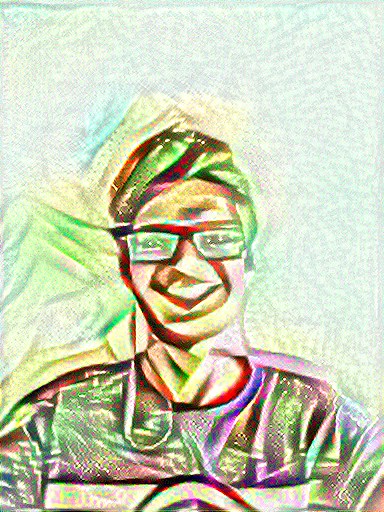

In [25]:
bI = deprocess_img(best_image)
Image.fromarray(bI)

In [26]:
ggI = exposure.equalize_hist(bI)

/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:124: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "


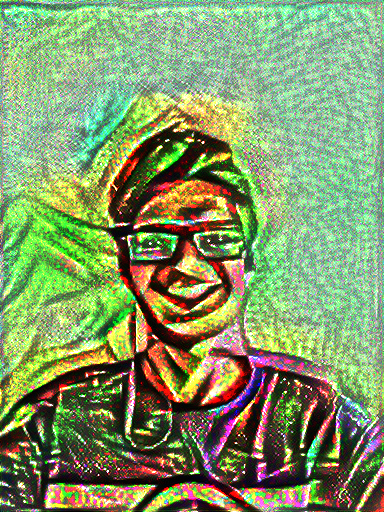

In [28]:
igI = (ggI*255).astype('uint8')
Image.fromarray(igI)

In [29]:
heI

NameError: ignored